In [1]:
#import sys
#print sys.executable
#print sys.path
#sys.path.append(['/Users/husseinsibai/Library/Python/2.7/lib/python/site-packages/control-0.7.0-py2.7.egg', '/Users/husseinsibai/Library/Python/2.7/lib/python/site-packages/nose-1.3.7-py2.7.egg', '/Users/husseinsibai/Library/Python/2.7/lib/python/site-packages/tornado-4.3-py2.7-macosx-10.10-intel.egg', '/Users/husseinsibai/Library/Python/2.7/lib/python/site-packages/backports_abc-0.4-py2.7.egg', '/Users/husseinsibai/Library/Python/2.7/lib/python/site-packages/certifi-2016.02.28-py2.7.egg', '/Users/husseinsibai/Library/Python/2.7/lib/python/site-packages/singledispatch-3.4.0.3-py2.7.egg', '/Users/husseinsibai/Library/Python/2.7/lib/python/site-packages/backports.ssl_match_hostname-3.5.0.1-py2.7.egg', '/anaconda3/lib/python2.7/site-packages', '/Users/husseinsibai/Desktop/MyPapers/multi-drone_simulator/MultiDroneSimulator', '/usr/local/Cellar/python@2/2.7.15_3/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/usr/local/Cellar/python@2/2.7.15_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/usr/local/Cellar/python@2/2.7.15_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/usr/local/Cellar/python@2/2.7.15_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/usr/local/Cellar/python@2/2.7.15_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/usr/local/Cellar/python@2/2.7.15_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/usr/local/Cellar/python@2/2.7.15_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/usr/local/Cellar/python@2/2.7.15_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Users/husseinsibai/Library/Python/2.7/lib/python/site-packages', '/usr/local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/site-packages/gtk-2.0', '/usr/local/lib/python2.7/site-packages/gtk-2.0'])
#sys.path

In [2]:
from scipy.integrate import odeint
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages/polytope')
import numpy as np
import math
from grid import Hyperrect
import itertools
import pdb
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from collections import deque 
from collections import defaultdict
#import polytope as pc
%matplotlib inline
from matplotlib.patches import Rectangle
SAFE = 1
UNSAFE = -1
UNKNOWN = 0

In [3]:
def getInitSetCenter(initialSet):
    center = len(initialSet[0][:])
    for i in range(len(center)):
        center[i] = (initialSet[0][i] + initialSet[1])/2
    return center

In [4]:
def doRectContains(rect1, rect2):
    for i in range(len(rect1[0][:])):
        if rect1[0][i] < rect2[0][i] or rect1[1][i] > rect2[1][i]:
            return False
    return True

In [5]:
def doRectsInter(rect1, rect2):
    for i in range(len(rect1[0][:])):
        if rect1[0][i] > rect2[1][i] or rect1[1][i] < rect2[0][i]:
            return False
    return True

In [6]:
def getSetIntIndex(sol, sett):
    for i in range(len(sol)):
        if isInSet(sol[i], sett):
            return i
    return -1

In [7]:
def bloatToTube(k, gamma, init_delta_array, trace, dimensions):
    center_trace = trace
    reach_tube = []
    trace_len = len(trace)
    for i in range(trace_len-1):
        #pdb.set_trace()
        time_interval = center_trace[i+1][0] - center_trace[0][0]
        lower_rec = [center_trace[i][0]]
        upper_rec = [center_trace[i+1][0]]

        for dim in range(1,dimensions):
            delta = k[dim-1] * math.exp(gamma[dim-1]*time_interval) * init_delta_array[dim-1]
            upper_rec.append(max(center_trace[i+1][dim],center_trace[i][dim])+delta)
            lower_rec.append(min(center_trace[i+1][dim],center_trace[i][dim])-delta)
        reach_tube.append(lower_rec)
        reach_tube.append(upper_rec)
    return reach_tube

In [8]:
def position(p, t, cd1, vc, m, k1, k2, k3, x_o, y_o, x_n, y_n):
    # get initial conditions
    v = p[0]            # velocity
    s = p[1]            # psi
    x = p[2]            # x_i
    y = p[3]            # y_i

    # constants
    g = 32.2            # ft/sec

    
    # compute dvdt
    D = cd1 * v**2      # drag
    T = k1*m*(vc - v)   # thrust
    dvdt = (T-D)/m      # v'

    # compute Fct, current crosstrack error
    p1 = np.array([x-x_o, y-y_o])
    p2 = np.array([x-x_n, y-y_n])
    lam = (p2-p1)/np.linalg.norm(p2-p1)
    Fct = np.linalg.norm(np.cross(lam, p1))

    # compute psi
    #sh_old = math.acos((y_n - y) / (math.sqrt((x_n - x)*(x_n - x) + (y_n - y)*(y_n - y))))
    #if y_n > y:
    #    sh = math.atan((x_n-x)/(y_n-y))
    #else:
    #    sh = (np.pi/2) + math.atan((y-y_n)/(x_n-x))
        
    dot = (y_n - y)      # dot product between [x1, y1] and [x2, y2]
    det = (x_n - x)      # determinant
    sh = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)
    '''
    if sh < 0 :
        sh = sh + 2 * math.pi
    if s < 0:
        s = s + 2 * math.pi
    '''
    #if (abs(sh_old - sh) > 0.001):
    #    pdb.set_trace()
    h = (k2*vc/g) * (sh - s) #+ k3*Fct
    #h = (k2*v/g) * (sh - s)
    dsdt = (g/v) * np.sin(h) # * (sh - s) #
    #print "dsdt: ", dsdt 
    #print "s: ", s
    #print "sh: ", sh

    dxdt = v * np.sin(s)
    dydt = v * np.cos(s)

    return [dvdt, dsdt, dxdt, dydt]

In [9]:
def standardized_position(p, t, cd1, vc, m, k1, k2, k3):
    # get initial conditions
    v = p[0]            # velocity
    s = p[1]            # psi
    x = p[2]            # x_i
    y = p[3]            # y_i
    
    # constants
    g = 32.2            # ft/sec
    
    # compute dvdt
    D = cd1 * v**2      # drag
    T = k1*m*(vc - v)   # thrust
    dvdt = (T-D)/m      # v'
    
    # compute Fct, current crosstrack error
    #p1 = np.array([x-p[2], y-p[3]])
    #p2 = np.array([x-x_n, y-y_n])
    #lam = (p2-p1)/np.linalg.norm(p2-p1)
    
    ##TODO: there is dependence on wp_o in Fct and on wp_n by psi (s here), so we will skip Fct for now
    # but need to handle it later
    #Fct = np.linalg.norm(y)
    
    #compute psi
    #sh_old = math.acos((- y) / (math.sqrt(x*x + y*y)))
    #if 0 > y:
    #    sh = math.atan((x)/(y))
    #else:
    #    sh = (np.pi/2) + math.atan((y)/(-x))
        
    #dot = y      # dot product between [x1, y1] and [x2, y2]
    #det = x      # determinant
    #sh = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)
    
    dot = -1*y      # dot product between [x1, y1] and [x2, y2]
    det = -1*x      # determinant
    sh = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)
    #if (abs(sh_old - sh) > 0.001):
    #    pdb.set_trace()
    #h = -1*(k2*v/g) * s #+ k3 * Fct
    h = (k2*v/g) * (sh - s)
    dsdt = (g/v) * np.sin(h)
    dxdt = v * np.sin(s)
    dydt = v * np.cos(s)
    #print "derivatives: ", dxdt, dydt

    return [dvdt, dsdt, dxdt, dydt]

In [10]:
def PointCoordinateChange(sc, p, x_n, y_n):
    v1 = p[0]            # velocity
    s1 = p[1]            # psi
    x1 = p[2]            # x_i
    y1 = p[3]            # y_i
    #y2 = (y1 - y_n)*math.cos(sc) +  (x1 - x_n)*math.sin(sc)
    #x2 = -(y1 - y_n)*math.sin(sc) + (x1 - x_n)*math.cos(sc)
    x2 = (x1 - x_n)*math.cos(sc) + (y1 - y_n)*math.sin(sc)
    y2 = -1*(x1 - x_n)*math.sin(sc) + (y1 - y_n)*math.cos(sc)
    s2 = s1 + sc
    v2 = v1
    return [v2, s2, x2, y2]

In [11]:
def List1dCoordinateChange(sc, l, x_n, y_n):
    L = []
    for i in range(len(l)):
        L.append(PointCoordinateChange(sc,l[i],x_n,y_n))
    return L

In [12]:
def List2dCoordinateChange(sc, l, x_n, y_n):
    L = []
    for i in range(len(l)):
        L.append(List1dCoordinateChange(sc, l[i], x_n, y_n))
    return L

In [13]:
PointCoordinateChange(math.pi/4, [1,0,0,6], 0, 0)

[1, 0.7853981633974483, 4.242640687119285, 4.242640687119286]

In [20]:
def PositionPointCoordinateChange(sc, x1,y1, x_n, y_n):
    print "Input", x1,y1,sc, x_n, y_n
    #x2 = (x1 - x_n)*math.cos(sc) +  (y1 - y_n)*math.sin(sc)
    #y2 = -(x1 - x_n)*math.sin(sc) + (y1 - y_n)*math.cos(sc)
    #y2 = (y1 - y_n)*math.cos(sc) +  (x1 - x_n)*math.sin(sc)
    #x2 = -(y1 - y_n)*math.sin(sc) + (x1 - x_n)*math.cos(sc)
    x2 = (x1 - x_n)*math.cos(sc) + (y1 - y_n)*math.sin(sc)
    y2 = -1*(x1 - x_n)*math.sin(sc) + (y1 - y_n)*math.cos(sc)
    print "Output:", x2,y2
    return [x2, y2]

In [21]:
def inversePointCoordinateChange(sc, p, x_n, y_n):
    v1 = p[0]            # velocity
    s1 = p[1]            # psi
    x1 = p[2]            # x_i
    y1 = p[3]            # y_i
    #y2 = y1*math.cos(sc) - x1*math.sin(sc) + y_n
    #x2 = y1*math.sin(sc) + x1*math.cos(sc) + x_n
    x2 = x1*math.cos(sc) - y1*math.sin(sc) + x_n
    y2 = x1*math.sin(sc) + y1*math.cos(sc) + y_n
    s2 = s1 - sc
    v2 = v1
    return [v2, s2, x2, y2]

In [22]:
inversePointCoordinateChange(math.pi/6,[1,0,2,0], 0, 0)

[1, -0.5235987755982988, 1.7320508075688774, 0.9999999999999999]

In [23]:
def mapInitialSet(sc, initialset, x_n, y_n):
    new_initialset = []
    initialset_transpose = list(map(list, zip(*np.array(initialset))))
    vertices = list(itertools.product(*initialset_transpose))
    new_vertices = []
    for vertex in vertices:
        #pdb.set_trace()
        new_vertex = PointCoordinateChange(sc, vertex, x_n, y_n)
        #print "new_vertex: ", new_vertex
        if len(new_initialset) == 0:
            new_initialset = [[new_vertex[0], new_vertex[1], new_vertex[2], new_vertex[3]],\
                              [new_vertex[0], new_vertex[1], new_vertex[2], new_vertex[3]]]
        else:
            new_initialset[0][0] = min(new_initialset[0][0], new_vertex[0])
            new_initialset[0][1] = min(new_initialset[0][1], new_vertex[1])
            new_initialset[0][2] = min(new_initialset[0][2], new_vertex[2])
            new_initialset[0][3] = min(new_initialset[0][3], new_vertex[3])
            new_initialset[1][0] = max(new_initialset[1][0], new_vertex[0])
            new_initialset[1][1] = max(new_initialset[1][1], new_vertex[1])
            new_initialset[1][2] = max(new_initialset[1][2], new_vertex[2])
            new_initialset[1][3] = max(new_initialset[1][3], new_vertex[3])
    return new_initialset
initset = [[0.5,0.6,-0.5,-0.5],[0.6, 0.7, 0.5, 0.5]]
sc = math.pi/3
wp_n = [0,0] #[3.5,0.5]
mapInitialSet(sc,initset, wp_n[0], wp_n[1])

[[0.5, 1.6471975511965975, -0.68301270189221941, -0.68301270189221941],
 [0.59999999999999998,
  1.7471975511965976,
  0.68301270189221941,
  0.68301270189221941]]

In [24]:
def mapRect(sc, initialset, x_n, y_n):
    new_initialset = []
    print initialset
    initialset_transpose = list(map(list, zip(*np.array(initialset)[:,1:])))
    print initialset_transpose
    vertices = list(itertools.product(*initialset_transpose))
    new_vertices = []
    for vertex in vertices:
        if len(vertex) != 4:
            pdb.set_trace()
        new_vertex = PointCoordinateChange(sc, vertex, x_n, y_n)
        #print "new_vertex: ", new_vertex
        if len(new_initialset) == 0:
            new_initialset = [[initialset[0][0], new_vertex[0], new_vertex[1], new_vertex[2], new_vertex[3]],\
                              [initialset[1][0], new_vertex[0], new_vertex[1], new_vertex[2], new_vertex[3]]]
        else:
            new_initialset[0][0] = min(new_initialset[0][0], new_vertex[0])
            new_initialset[0][1] = min(new_initialset[0][1], new_vertex[1])
            new_initialset[0][2] = min(new_initialset[0][2], new_vertex[2])
            new_initialset[0][3] = min(new_initialset[0][3], new_vertex[3])
            new_initialset[1][0] = max(new_initialset[1][0], new_vertex[0])
            new_initialset[1][1] = max(new_initialset[1][1], new_vertex[1])
            new_initialset[1][2] = max(new_initialset[1][2], new_vertex[2])
            new_initialset[1][3] = max(new_initialset[1][3], new_vertex[3])
    return new_initialset
initset = [[0, 0.5, 0.9, -0.5, -0.5],[0.1, 0.6, 0.91, 0.5, 0.5]]
print list(map(list, zip(*np.array(initset)[:,1:])))
sc = 1.32581766367
wp_n = [3.5,0.5]
mapRect( sc,initset, wp_n[0], wp_n[1])

[[0.5, 0.59999999999999998], [0.90000000000000002, 0.91000000000000003], [-0.5, 0.5], [-0.5, 0.5]]
[[0, 0.5, 0.9, -0.5, -0.5], [0.1, 0.6, 0.91, 0.5, 0.5]]
[[0.5, 0.59999999999999998], [0.90000000000000002, 0.91000000000000003], [-0.5, 0.5], [-0.5, 0.5]]


[[0, 0.5, -1.9402850002835055, -1.9402850002835055, 3.6380343755488127],
 [0.59999999999999998,
  2.2358176636700002,
  2.22581766367,
  3.8805700005832366,
  3.6380343755488127]]

old vertex:  (11.9, 5.1)
Input 11.9 5.1 -1.32581766367 3.5 0.5
Output: -2.42535625038 9.26486087638
new vertex:  [-2.4253562503815593, 9.264860876383148]
old vertex:  (11.9, 6.1)
Input 11.9 6.1 -1.32581766367 3.5 0.5
Output: -3.39549875053 9.50739650142
new vertex:  [-3.3954987505273686, 9.507396501417572]
old vertex:  (12.9, 5.1)
Input 12.9 5.1 -1.32581766367 3.5 0.5
Output: -2.18282062535 10.2350033765
new vertex:  [-2.182820625347135, 10.235003376528958]
old vertex:  (12.9, 6.1)
Input 12.9 6.1 -1.32581766367 3.5 0.5
Output: -3.15296312549 10.4775390016
new vertex:  [-3.152963125492944, 10.477539001563382]
u: [[11.9, 5.1], [12.9, 6.1]]
11.9 5.1
Input 11.9 5.1 -1.32581766367 3.5 0.5
Output: -2.42535625038 9.26486087638
[-2.4253562503815593, 9.264860876383148]


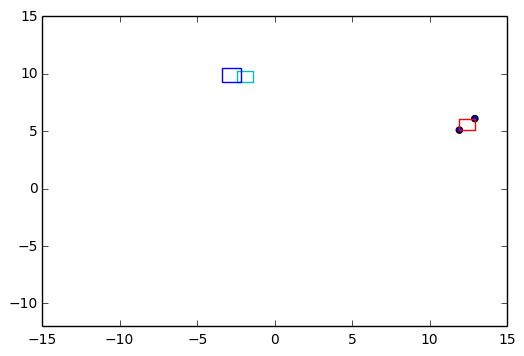

In [25]:
def mapUnsafeSets(sc,unsafesets, x_n, y_n):
    new_unsafesets = []
    #pdb.set_trace()
    for u in unsafesets:
        u = list(map(list, zip(*u)))
        vertices = list(itertools.product(*u))
        new_vertices = []
        new_u = []
        for vertex in vertices:
            print "old vertex: ", vertex
            new_vertex = PositionPointCoordinateChange(sc, vertex[0], vertex[1], x_n, y_n)
            print "new vertex: ", new_vertex
            new_vertices.append(new_vertex)
            #print "new_vertex: ", new_vertex
            if len(new_u) == 0:
                new_u = [[new_vertex[0], new_vertex[1]], [new_vertex[0],new_vertex[1]]]
            else:
                new_u[0][0] = min(new_u[0][0], new_vertex[0])
                new_u[0][1] = min(new_u[0][1], new_vertex[1])
                new_u[1][0] = max(new_u[1][0], new_vertex[0])
                new_u[1][1] = max(new_u[1][1], new_vertex[1])
        #new_unsafesets.append(pc.qhull(new_vertices))
        new_unsafesets.append(new_u)
    return new_unsafesets

drone_num = 3
#initsets = [[[35, 0.9, 2600, -750],[35.1, 0.91, 2600.5, -749.5]]]
initsets = [[[0.5, 0.9, -0.5, -0.5],[0.6, 0.91, 0.5, 0.5]], [[0.5, 0.9, -0.5, -0.5],[0.6, 0.91, 0.5, 0.5]], [[0.5, 0.9, -0.5, -0.5],[0.6, 0.91, 0.5, 0.5]]]
res = [0.05,0.05, 0.5, 0.5]
waypointslists = [[[5.2,-1.5],[10,-4], [11.5,7],[15,8.5], [18.5,7.5]],\
                  [[2.5,0.5],[13.2,5], [14,8],[17.2,10]],\
                  [[3,-1],[10,3], [12,6.25],[15,8], [19,9]]]
#waypointslists = [[[2.5,0.5],[13.2,5]],\
#                  [[3,-1],[10,3]],\
#                  [[5.2,-1.5],[2,3]]]
goalwidth = [0.25,0.25]
unsafesets = [[[11.9,5.1],[12.9,6.1]]]
sc = 1.32581766367
wp_n = [3.5,0.5]
u_transs = mapUnsafeSets(-1*sc,unsafesets, wp_n[0], wp_n[1])
u_trans = u_transs[0]
u = unsafesets[0]
print "u:",u
plt.figure()
plt.scatter([u[0][0],u[1][0]],[u[0][1],u[1][1]])
#for vertex in new_vertices:
#    plt.scatter(vertex[0], vertex[1])
currentAxis = plt.gca()
rect1 = Rectangle((u[0][0],u[0][1]),u[1][0]-u[0][0],u[1][1]-u[0][1],linewidth=1,edgecolor='r',facecolor='none')
currentAxis.add_patch(rect1)
print u[0][0],u[0][1]
bottom_left =  PositionPointCoordinateChange(-1*sc, u[0][0],u[0][1], wp_n[0], wp_n[1])
print bottom_left
rect2 = Rectangle((bottom_left[0],bottom_left[1]),u[1][0]-u[0][0],u[1][1]-u[0][1],linewidth=1,edgecolor='c',facecolor='none')
#rotation = mpl.transforms.Affine2D().rotate_deg_around(wp_n[0], wp_n[1], -sc) + plt.gca().transData
#rect2.set_transform(rotation)
currentAxis.add_patch(rect2)
rect3 = Rectangle((u_trans[0][0],u_trans[0][1]),u_trans[1][0]-u_trans[0][0],u_trans[1][1]-u_trans[0][1],linewidth=1,edgecolor='b',facecolor='none')
currentAxis.add_patch(rect3)
plt.ylim([-12,15])
plt.xlim([-15,15])
plt.show()

In [27]:
center = [0.5, 0.9, -0.5, -0.5]
#center = [0.5, 0.9, 4, 0.4]
#center = [0.59842297193031813, -2.206913072407672, 3.1468243300079055, 1.1631997589706611]
#center = [0.59936506472892492, -2.4263507917855276, 2.8037938394732453, 0.49054103436623531]
time_step = 0.1
time_bound = 30
number_points = int(np.ceil(time_bound/time_step))
t = [i*time_step for i in range(0,number_points)]
if t[-1] != time_step:
    t.append(time_bound)
newt = []
for step in t:
    newt.append(float(format(step, '.2f')))
t = newt
while t[-1] == t[-2]:
    t.pop()

red_args = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-6)
red_args_orig = (0.002, 0.6, 0.1, 1, 1.5, 1*10**1, center[2], center[3],3.5,0.5)
red_args = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-6, center[2], center[3],0,0)
sc = 0

#wp_o = [center[2],center[3]]
#wp_n = [3.5,0.5]
#sc = math.acos((wp_n[1] - wp_o[1]) / (math.sqrt((wp_n[0] - wp_o[0])*(wp_n[0] - wp_o[0]) + (wp_n[1] - wp_o[1])*(wp_n[1] - wp_o[1]))))
#print "sc new: ", sc
#if 0.5 > center[3]:
#    sc = math.atan((wp_n[0]-(center[2]))/(wp_n[1]-(center[3])))
#else:
#    sc = (np.pi/2) + math.atan((center[3]-wp_n[1])/(wp_n[0]-(center[2])))
#print "sc old:",sc

dot = (wp_n[1] - center[3])      # dot product between [x1, y1] and [x2, y2]
det = (wp_n[0] - center[2])      # determinant
sc = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)


center_trans = PointCoordinateChange(-1*sc, center, wp_n[0], wp_n[1])
#sol = odeint(standardized_position,center_trans,t,args=red_args, hmax = time_step)
sol_orig = odeint(position,center,t,args=red_args_orig, hmax = time_step)
sol = odeint(position,center,t,args=red_args_orig, hmax = time_step)
#sol = odeint(position,center_trans,t,args=red_args, hmax = time_step)
#for i in range(len(sol)):
#    print sol[i], inversePointCoordinateChange(-1*sc,sol[i],wp_n[0], wp_n[1]), sol_orig[i]
#    print "difference in angle : ", sol[i][1] - sol_orig[i][1]
    #print "difference with true : ", sol[i][1] - sol_orig[i][1]
    
unsafesets = [[[11.9,5.1],[12.9,6.1]]]

Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.


[[ 0.5         0.9        -0.5        -0.5       ]
 [ 0.50903151  0.96996457 -0.45937406 -0.4700896 ]
 [ 0.51718693  1.02831204 -0.41619535 -0.44237004]
 ..., 
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Reached
Reached


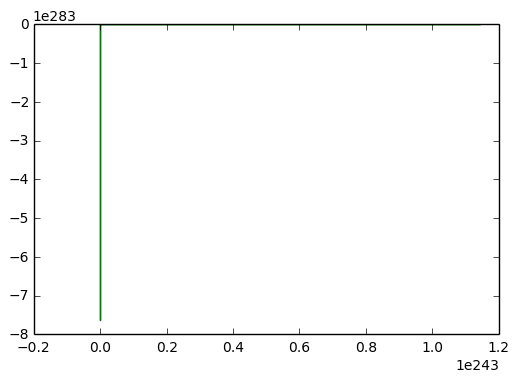

In [28]:
%matplotlib inline
#plt.plot(np.array(sol[:])[:,2],np.array(sol[:])[:,3],'b')
plt.plot(np.array(sol_orig[:])[:,2],np.array(sol_orig[:])[:,3],'g')
print sol_orig
#plt.plot(t,np.array(sol_orig[:])[:,1],'g')
#inverted_sol =[]
for i in range(len(sol)):
    if abs(sol_orig[i][2] - 3.5) < 0.05 and abs(sol_orig[i][3] - 0.5) < 0.05:
        print "Reached"
    #inverted_sol.append(inversePointCoordinateChange(-1*sc,sol[i],3.5,0.5))
#print inverted_sol
#plt.axis('scaled')
#plt.plot(np.array(inverted_sol[:])[:,2],np.array(inverted_sol[:])[:,3],'r')
#plt.plot(t,np.array(inverted_sol[:])[:,1],'r')

### def TC_Simulate(Mode,initialCondition,time_bound):
    time_step = 0.1;
    time_bound = float(time_bound)

    number_points = int(np.ceil(time_bound/time_step))
    t = [i*time_step for i in range(0,number_points)]
    if t[-1] != time_step:
        t.append(time_bound)
    newt = []
    for step in t:
        newt.append(float(format(step, '.2f')))
    t = newt
    while t[-1] == t[-2]:
        t.pop()
    red_args = 0
    if Mode=="first;first":
        red_args = (0.002, 30, 1, 1.5, 0.6, 1*10**-6, 2600, -750, 5000, 2000)
    elif Mode=="second;second":
        red_args = (0.002, 30, 1, 1.5, 0.6, 1*10**-6, 5000, 2000, 5750, 3500)
    elif Mode=="third;third":
        red_args = (0.002, 30, 1, 1.5, 0.6, 1*10**-6, 5750, 3500, 7500, 4250)
    elif Mode=="fourth;fourth":
        red_args = (0.002, 30, 1, 1.5, 0.6, 1*10**-6, 7500, 4250, 9250, 3750)
    print "InitialCondition:",initialCondition
    sol = odeint(position,initialCondition,t,args=red_args, hmax = time_step)
    # Construct the final output
    trace = []
    for j in range(len(t)):
        #print t[j], current_psi
        tmp = []
        tmp.append(t[j])
        tmp.append(float(sol[j,0]))
        tmp.append(float(sol[j,1]))
        tmp.append(float(sol[j,2]))
        tmp.append(float(sol[j,3]))
        trace.append(tmp)
    return np.array(trace)

In [29]:
def time_List(time_step, time_bound):
    number_points = int(np.ceil(time_bound/time_step))
    t = [i*time_step for i in range(0,number_points)]
    if t[-1] != time_step:
        t.append(time_bound)
    newt = []
    for step in t:
        newt.append(float(format(step, '.2f')))
    t = newt
    while t[-1] == t[-2]:
        t.pop()
    return t

In [30]:
def TC_Simulate_Single(d, initState, waypointslist, time_step, time_bound, traces, computed_sims, res, k, gamma, computed_tubes, unsafesets):
    cur_goal = 0
    #time_left = time_bound
    time_passed = 0
    time_bound_unit = time_bound
    
    c_num_computed_sims = 0
    c_num_trans_sims = 0

    wp_o = [initState[2],initState[3]]
    wp_n = waypointslist[cur_goal]
    trace = []
    trace_orig = []
    trace_unified = []
    trace_unified.append([])
    tube_unified = []
    tube_unified.append([])
    unsafesets_unified = []
    unsafesets_unified.append([])
    #unsafe_d = [0]*drone_num
    satisfiedGuard = False
    unsafe = False
    while cur_goal < len(waypointslist):
        satisfiedGuard = False
        transformed = False
        time_bound = time_bound_unit
        t = time_List(time_step, time_bound)
        red_args_orig = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-2, wp_o[0], wp_o[1], wp_n[0], wp_n[1])
        #red_args = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-6)
        red_args = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-2, wp_o[0], wp_o[1], 0, 0)
        #sc = 0
        #sc_old = math.acos((wp_n[1] - wp_o[1]) / (math.sqrt((wp_n[0] - wp_o[0])*(wp_n[0] - wp_o[0]) + (wp_n[1] - wp_o[1])*(wp_n[1] - wp_o[1]))))
        #if wp_n[1] > wp_o[1]:
        #    sc = math.atan((wp_n[0]-wp_o[0])/(wp_n[1]-wp_o[1]))
        #else:
        #    sc = (np.pi/2) + math.atan((wp_o[1]-wp_n[1])/(wp_n[0]-wp_o[0]))
            
        dot = (wp_n[1] - wp_o[1])      # dot product between [x1, y1] and [x2, y2]
        det = (wp_n[0] - wp_o[0])      # determinant
        sc = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)
        #if (abs(sc - sc_old) > 0.001):
        #    pdb.set_trace()
        unsafesets_trans = mapUnsafeSets(-1*sc, unsafesets, wp_n[0], wp_n[1])
        initState_trans = PointCoordinateChange(-1*sc, initState, wp_n[0], wp_n[1])
        initState_trans_ref = [initState_trans[0], math.pi - initState_trans[1], -1 * initState_trans[2], initState_trans[3]] 
        initState_trans_ref_2 = [initState_trans[0], -1 * initState_trans[1], initState_trans[2], -1 * initState_trans[3]] 
        initState_trans_ref_3 = [initState_trans[0], math.pi/2 - initState_trans[1], initState_trans[3], initState_trans[2]] 
        initState_trans = quantize_uniform(initState_trans, res)
        ke = tuple(initState_trans)
        ke_ref = tuple(initState_trans_ref)
        ke_ref_2 = tuple(initState_trans_ref_2)
        ke_ref_3 = tuple(initState_trans_ref_2)
        if ke in computed_sims:
            sol = computed_sims[ke]
            tube = computed_tubes[ke]
            c_num_trans_sims = c_num_trans_sims + 1
            print "solution is cached already 1"
            transformed = True
        elif ke_ref in computed_sims:
            sol = computed_sims[ke]
            for i in range(len(sol)):
                sol[i][2] = -1 * sol[i][2]
                sol[i][1] = math.pi - sol[i][1]
            print "solution is cached already 2"
            c_num_trans_sims = c_num_trans_sims + 1 
            transformed = True
        elif ke_ref_2 in computed_sims:
            sol = computed_sims[ke]
            for i in range(len(sol)):
                sol[i][3] = -1 * sol[i][3]
                sol[i][1] = -1 * sol[i][1]
            c_num_trans_sims = c_num_trans_sims + 1 
            print "solution is cached already 3"
            transformed = True
        elif ke_ref_3 in computed_sims:
            sol = computed_sims[ke]
            for i in range(len(sol)):
                temp = sol[i][3]
                sol[i][3] = sol[i][2]
                sol[i][2] = temp
                sol[i][1] = math.pi/2 - sol[i][1]
            c_num_trans_sims = c_num_trans_sims + 1
            print "solution is cached already 4"
            transformed = True
        else:
            c_num_computed_sims = c_num_computed_sims + 1
        
        if transformed:
            time_bound = time_step * (len(sol) -1)
            t = time_List(time_step, time_bound)
        else:
            computed_sims[ke] = []
            
        while not satisfiedGuard:
            if not transformed:
                #sol = odeint(standardized_position,initState_trans,t,args=red_args, hmax = time_step)
                sol = odeint(position,initState_trans,t,args=red_args, hmax = time_step)
                if len(computed_sims[ke]) > 0:
                    initState = trace[-1][1:]
                else:
                    initState = inversePointCoordinateChange(-1*sc, initState_trans, wp_n[0], wp_n[1])
            sol_orig = odeint(position,initState,t,args=red_args_orig, hmax = time_step)
            for i in range(len(sol)):
                s = sol[i]
                #print "s: ", s
                if len(computed_sims[ke]) > 0 and i==0 and len(trace) > 0: # skip the first state since it already appeared as the last one in the previous part of the trace
                    continue
                if not transformed:
                    computed_sims[ke].append(s)
                
                if len(sol) != len(t) or len(sol)!=len(sol_orig):
                    pdb.set_trace()
                tmp_unified = []
                tmp_unified.append(time_passed + t[i])
                tmp_unified.append(float(sol[i][0]))
                tmp_unified.append(float(sol[i][1]))
                tmp_unified.append(float(sol[i][2]))
                tmp_unified.append(float(sol[i][3]))
                trace_unified[cur_goal].append(tmp_unified)
                tmp = []
                tmp.append(time_passed + t[i])
                tmp.extend(inversePointCoordinateChange(-1*sc, tmp_unified[1:], wp_n[0], wp_n[1]))
                trace.append(tmp)

                tmp_orig = []
                tmp_orig.append(time_passed + t[i])
                tmp_orig.append(float(sol_orig[i][0]))
                tmp_orig.append(float(sol_orig[i][1]))
                tmp_orig.append(float(sol_orig[i][2]))
                tmp_orig.append(float(sol_orig[i][3]))
                trace_orig.append(tmp_orig)
                # Checking dynamic unsafety with respect to other drones
                '''
                for od in range(d):
                    for ci in range(len(traces[od])):
                        if not abs(time_bound - time_left + t[i] - traces[od][ci][i][0]) < 0.5:
                            print "misalignment of time!"
                            break
                        if abs(s[2] - traces[od][ci][i][2]) < 0.02 and abs(s[3] - traces[od][ci][i][3]) < 0.02:
                            unsafe_d[d] = 1
                            unsafe_d[od] = 1
                ''' 
                # checking static safety with respect to static unsafe sets (buildings, mountains,...)
                #if not unsafe_d[d]:
                #    for u in trans_unsafesets:
                #        if s[2] >= u[0][0] and s[2] <= u[1][0] and \
                #           s[3] >= u[0][1] and s[3] <= u[1][1]:
                #            print "Drone ", d, "is unsafe."
                                                         
                #x_n = 0
                #y_n = 0
                # check if we reached the goal
                if abs(s[2]) < goalwidth[0] and abs(s[3]) < goalwidth[1]:
                    satisfiedGuard = True
                    print "Drone ", d, "reached waypoint ", wp_n,  "at time: ", time_passed + time_bound + t[i], " starting from ", center  
                    #if ke not in computed_sims:
                    #    computed_sims[ke] = []
                    #    computed_sims[ke].extend(sol[1:i+1]) # the last state is the first state, no need to repeat it
                    #else:
                    #    computed_sims[ke].extend(sol[:i+1])
                    trans_tube = bloatToTube(k, gamma, res, trace_unified[cur_goal], len(initState)+1)
                    if not transformed:
                        computed_tubes[ke] = trans_tube
                    tube_unified[cur_goal] = trans_tube
                    
                    unsafesets_unified[cur_goal] = unsafesets_trans
                    
                    if not unsafe:
                        for u in unsafesets_trans:
                            print "u:", u[0][:]
                            for j in range(0,len(trans_tube)-1,2):
                                print "trans_tube[j]: ", trans_tube[j][3:] 
                                print "trans_tube[j+1]: ", trans_tube[j+1][3:] 
                                if doRectsInter(u, [trans_tube[j][3:], trans_tube[j+1][3:]]):
                                    unsafe = True
                                    print "Drone ", d, "is unsafe."
                    
                    
                    #for j in range(0, len(trans_tube), 2):
                    #    cur_rect = mapRect(sc, [trans_tube[j],trans_tube[j+1]], wp_n[0], wp_n[1])
                    #    tube_unified[cur_goal].append(cur_rect[0])
                    #    tube_unified[cur_goal].append(cur_rect[1])
                    #print "computed_sims: ", computed_sims[ke]

                    #trace = trace[:i]
                    #return [trace, trace_unified, trace_orig], unsafe_d
                    #if cur_goal == 0:
                    #for j in range(3,len(trace_orig[-1])):
                    #    if abs(trace_orig[-1][j]-trace[-1][j]) > 0.4:
                    #        print "wrong conversion!!!!!"
                    #        pdb.set_trace()
                    #        return
                    #time_left = float(time_left - t[i])
                    #t = time_List(time_step, time_bound)

                    wp_o = waypointslist[cur_goal]
                    cur_goal = cur_goal + 1
                    if cur_goal >= len(waypointslist):
                        print "All waypoints are reached by drone", d, " :)"
                        time_left = 0
                        break
                    tube_unified.append([])
                    trace_unified.append([])
                    unsafesets_unified.append([])
                    wp_n = waypointslist[cur_goal]
                    break
            initState_trans = sol[i]
        initState = trace[-1][1:] # this should be a quantized version of the last state
        time_passed = time_passed + time_bound
        #if not satisfiedGuard:
        #    time_bound = time_bound + time_bound_unit
        #elif time_bound > time_bound_unit:
        #    time_bound = time_bound - time_bound_unit
        #if i >= len(sol)-1:
        #    break
    return trace, tube_unified, trace_orig, trace_unified, unsafe, c_num_computed_sims, c_num_trans_sims, unsafesets_unified

In [31]:
def quantize_uniform(p, delta):
    v = p[0]            # velocity
    s = p[1]            # psi
    x = p[2]            # x_i
    y = p[3]            # y_i
    v_new = math.floor(v / delta[0]) * delta[0]
    s_new = math.floor(s / delta[1]) * delta[1]
    x_new = math.floor(x / delta[2]) * delta[2]
    y_new = math.floor(y / delta[3]) * delta[3]
    return [v_new, s_new, x_new, y_new]

In [32]:
def TC_Simulate_Group(drone_num, initsets, res, waypointslists, goalwidth, unsafesets, time_bound):
    # res is a 1d list of length n, the dimension of the system
    assert drone_num > 0, "There should be at least one drone to simulate"
    assert drone_num <= len(initsets) and drone_num <= len(waypointslists)
    assert len(res) == len(initsets[0][0]), "Length of the resolution vectos is different than the number of dimensions"
    
    time_step = 0.1;
    time_bound = float(time_bound)
    
    initRects = [Hyperrect(initset[0],initset[1]) for initset in initsets]
    print "initRects: ", len(initRects)
    for d in range(len(initRects)):
        initRects[d].grid_all(res)
        
    #unified_initRects = []
    #for d in range(len(initRects)):
    #    unified_initRects.append(List2dCoordinateChange(sc, l, x_n, y_n))
        
    # convert all the initial sets to the unified coordinate system
    # find the hyperrectangle with the smallest volume that contains all the initial sets
    # grid it 
    # simulate till from all centers of cells in the grid till the first waypoint (origin of the unified system)
    # observation: if you start from the same unified state, you will reach the next waypoint in the same time
    # hence, if a 
    tubes = {}
    traces = {}#defaultdict(lambda: [])
    traces_orig = {}#defaultdict(lambda: [])
    traces_unified = {}#defaultdict(lambda: [])
    computed_sims = {}#defaultdict(lambda: [])
    computed_tubes = {}
    unsafesetss_unified = {}
    unsafe_d = [0]*drone_num
    num_computed_sims = 0
    num_trans_sims = 0
    for d in range(drone_num):
        centers = list(itertools.product(*initRects[d].gridlist))
        tubes[d] = []
        traces[d] = []
        traces_orig[d] = []
        traces_unified[d] = []
        for center in centers:
            print "Simulating the ", d, "th drone starting from ", center
            center = list(center)
            #center = quantize_uniform(center, res)
            #ke = tuple(center)
            #if ke in computed_traces:
            #    trace, trace_orig, trace_unified, unsafe_d = computed_traces[ke]
            #    num_trans_traces = num_trans_traces + 1
            #else:
            k=[1]*len(res)
            gamma = [0]*len(res)
            waypointslist =  waypointslists[d]
            trace, tube, trace_orig, trace_unified, unsafe, c_num_computed_sims, c_num_trans_sims, unsafesets_unified = TC_Simulate_Single(d, center, waypointslist, time_step, time_bound, traces, computed_sims, res, k, gamma, computed_tubes, unsafesets)
            
            #num_computed_traces = num_computed_traces + 1
            num_computed_sims = num_computed_sims + c_num_computed_sims 
            num_trans_sims = num_trans_sims + c_num_trans_sims
            tubes[d].append(tube)
            traces[d].append(trace)
            traces_orig[d].append(trace_orig)
            traces_unified[d].append(trace_unified)
            if unsafe:
                unsafe_d[d] = unsafe
            if d not in unsafesetss_unified:
                unsafesetss_unified[d] = unsafesets_unified
    return traces, tubes, traces_orig, traces_unified, unsafe_d, num_computed_sims, num_trans_sims, unsafesetss_unified

In [33]:
drone_num = 1#3
#[[0.5,0.6,-0.75,-0.75],[1, 1.1, 0.75, 0.75]].
initsets = [[[0.5,0.6,-0.5,-0.5],[0.6, 0.7, 0.5, 0.5]], [[0.5,0.6,0.5,0.5],[0.6, 0.7, 1.5, 1.5]], 
[[0.5, 1.6471975511965975, -0.68301270189221941, -0.68301270189221941],
 [0.59999999999999998,
  1.7471975511965976,
  0.68301270189221941,
  0.68301270189221941]]]
#initsets = [[[0.5, 0.9, -0.5, -0.5],[0.6, 0.91, 0.5, 0.5]], [[0.5, 0.9, -0.5, -0.5],[0.6, 0.91, 0.5, 0.5]], [[0.5, 0.9, -0.5, -0.5],[0.6, 0.91, 0.5, 0.5]]]
res = [0.05,0.05, 0.5, 0.5]
#waypointslists = [[[5.2,-1.5],[10,-4], [11.5,7],[15,8.5], [18.5,7.5]],\
#                  [[2.5,0.5],[13.2,5], [14,8],[17.2,10]],\
#                  [[3,-1],[10,3], [12,6.25],[15,8], [19,9]]]
sc = math.pi/3
waypointslists = [[[10,0],[10,10], [0,10], [0,20],[10,20]], \
                  [[11,1],[11,11], [1,11], [1,21],[11,21]], \
                  [PositionPointCoordinateChange(sc, 10,0,0,0),\
                    PositionPointCoordinateChange(sc, 10,10,0,0),\
                        PositionPointCoordinateChange(sc, 0,10,0,0),\
                          PositionPointCoordinateChange(sc, 0,20,0,0),\
                            PositionPointCoordinateChange(sc, 10,20,0,0)]
                 ] #[0,20],[10,20]]]
goalwidth = [0.25,0.25]
#unsafesets = [[[11.9,5.1],[12.9,6.1]]]
unsafesets = [[[5,11],[5.5,12]]]

In [34]:
traces, tubes, traces_orig, traces_unified, unsafe_d, num_computed_sims, num_trans_sims, unsafesetss_unified = TC_Simulate_Group(drone_num, initsets, res, waypointslists, goalwidth, unsafesets, 10)

initRects:  3
Simulating the  0 th drone starting from  (0.525, 0.625, -0.25, -0.25)
old vertex:  (5, 11)
new vertex:  [-11.118644559347093, -4.730300536213456]
old vertex:  (5, 12)
new vertex:  [-12.118347249990142, -4.705917543758747]
old vertex:  (5.5, 11)
new vertex:  [-11.106453063119739, -4.230449190891931]
old vertex:  (5.5, 12)
new vertex:  [-12.106155753762788, -4.206066198437222]
Drone  0 reached waypoint  [10, 0] at time:  17.6  starting from  [0.5, 0.9, -0.5, -0.5]
u: [-12.118347249990142, -4.730300536213456]
trans_tube[j]:  [-1.0401858198108818, -11.0]
trans_tube[j+1]:  [0.0, -9.969084852038199]
trans_tube[j]:  [-1.0792341959108982, -10.969084852038199]
trans_tube[j+1]:  [-0.04018581981088176, -9.93475730828331]
trans_tube[j]:  [-1.116946103795486, -10.93475730828331]
trans_tube[j+1]:  [-0.0792341959108982, -9.897372058386006]
trans_tube[j]:  [-1.1531805330530736, -10.897372058386006]
trans_tube[j+1]:  [-0.11694610379548587, -9.857256049734197]
trans_tube[j]:  [-1.18784248

In [ ]:
print unsafe_d

In [ ]:
print num_computed_sims, num_trans_sims

In [ ]:
colors = ['b','g', 'y']
plt.figure()
currentAxis = plt.gca()

unified = False
for d in range(drone_num): # drone_num
    
    color = colors[d]
    if not unified:
        wp = np.array(waypointslists[d])
        if d == 0:
            plt.plot(wp[:,0],wp[:,1],'k'+'o', label='waypoints')
            plt.plot(wp[:,0],wp[:,1],'k')
        else: 
            plt.plot(wp[:,0],wp[:,1],'k'+'o')
            plt.plot(wp[:,0],wp[:,1],'k')
    
    for ci in range(len(traces[d])): # len(traces[d])
        if not unified:
            if ci == 0 and d == 0:
                plt.plot(np.array(traces[d][ci][:])[:,3],np.array(traces[d][ci][:])[:,4],color, label='transformed simulations')
                plt.plot(np.array(traces_orig[d][ci][:])[:,3],np.array(traces_orig[d][ci][:])[:,4],'c', label='original simulations')
            else:
                plt.plot(np.array(traces[d][ci][:])[:,3],np.array(traces[d][ci][:])[:,4],color)
                plt.plot(np.array(traces_orig[d][ci][:])[:,3],np.array(traces_orig[d][ci][:])[:,4],color)
        
        else:
            #print np.array(traces_unified[d][ci][:])
            for seg in range(len(traces_unified[d][ci])): #len(traces_unified[d][ci])
                if ci == 0 and d == 0 and seg == 0:
                    plt.plot(np.array(traces_unified[d][ci][seg][:])[:,3],np.array(traces_unified[d][ci][seg][:])[:,4],'k' + '-',label = 'cached simulations')
                else:    
                    plt.plot(np.array(traces_unified[d][ci][seg][:])[:,3],np.array(traces_unified[d][ci][seg][:])[:,4],'k' + '-')
                for i in range(0,len(tubes[d][ci][seg][:])-9,10):
                #    #pdb.set_trace()
                #    #print "lower", tubes[d][ci][seg][i][3:]
                #    #print "upper", tubes[d][ci][seg][i+1][3:]
                    w = tubes[d][ci][seg][i+1][3] - tubes[d][ci][seg][i][3]
                    h = tubes[d][ci][seg][i+1][4] - tubes[d][ci][seg][i][4]
                    rect = Rectangle((tubes[d][ci][seg][i][3],tubes[d][ci][seg][i][4]),w,h,linewidth=1,edgecolor=color,facecolor='none')
                #    # Add the patch to the Axes
                    currentAxis.add_patch(rect)
    if unified:
        for seg in range(len(unsafesetss_unified[d])):
            unsafesets_unified = unsafesetss_unified[d][seg]
            for u in unsafesets_unified:
                print "u:", u
                print "unsafetsets_unified: ", unsafesets_unified
                rect = Rectangle((u[0][0],u[0][1]),u[1][0]-u[0][0],u[1][1]-u[0][1],linewidth=1,edgecolor='r',facecolor='none')
                currentAxis.add_patch(rect)
        
        #for u in unsafesets:
        #    for waypointlist in waypointslists:
        #        for i in range(len(waypointlist)-1):
        #            wp_n = waypointlist[i+1]
        #            wp_o = waypointlist[i]
        #            dot = (wp_n[1] - wp_o[1])      # dot product between [x1, y1] and [x2, y2]
        #            det = (wp_n[0] - wp_o[0])      # determinant
        #            sc = math.atan2(det, dot)
        #            rect = Rectangle((u[0][0]-wp_n[0],u[0][1]-wp_n[1]),u[1][0]-u[0][0],u[1][1]-u[0][1],linewidth=1,edgecolor='c',facecolor='none')
        #            rotation = mpl.transforms.Affine2D().rotate_deg_around(wp_n[0], wp_n[1], -sc) + plt.gca().transData
        #            rect.set_transform(rotation)
        #            currentAxis.add_patch(rect)

if not unified:
    for u in unsafesets:
        print "u:", u
        rect = Rectangle((u[0][0],u[0][1]),u[1][0]-u[0][0],u[1][1]-u[0][1],linewidth=1,edgecolor='r',facecolor='none')
        currentAxis.add_patch(rect)

plt.legend()
#plt.ylim([-12,4])
#plt.xlim([-13,12])
plt.xlabel('x')
plt.ylabel('y')
#plt
plt.show()

In [ ]:
print unsafesets

In [ ]:
#%matplotlib inline
colors = ['r','b','g']

for d in range(2): # drone_num
    color = colors[d]
    
    wp = np.array(waypointslists[d])
    plt.plot(wp[:,0],wp[:,1],'k'+'o')
    plt.plot(wp[:,0],wp[:,1],'k')
    for ci in range(len(traces[d])):
        plt.plot(np.array(traces[d][ci][:])[:,3],np.array(traces[d][ci][:])[:,4], color)


# Create a Rectangle patch
for u in unsafesets:
    print "u",u
    u = np.array(u)
    rectpoints = [[u[0][0],u[0][1]],[u[1][0],u[0][1]],\
                  [u[1][0],u[0][1]],[u[1][0],u[1][1]],\
                  [u[0][0],u[1][1]],[u[0][0],u[0][1]]]
    rectpoints = np.array(rectpoints)
    plt.plot(rectpoints[:,0], rectpoints[:,1], 'y')
    
plt.show()

In [ ]:
def isInSet(pointt, sett):
    assert len(pointt) == len(sett[0][:])
    for i in range(len(pointt)):
        if pointt[i] > sett[1][i] or pointt[i] < sett[0][i]:
            return False 
    return True

In [ ]:
def computeTube(k, gamma, initset, goalset, unsafesets, dimensions, time_step, time_bound):
    queue = deque([initset])
    red_args = (0.002, 0.6, 1, 1.5, 0.6, 1*10**-6)
    t = time_List(time_step, time_bound)
    safe = True
    while len(queue) > 0:
        cur_initset = initqueue.popleft()
        cur_center = getInitSetCenter([cur_initset.lowerBound, cur_initset.upperBound])
        sol = odeint(standardized_position,cur_center,t,args=red_args, hmax = time_step)
        for unsafeset in unsafesets:
            interIndex = getSetIntIndex(sol, unsafeset)
            if interIndex == -1:
                safe = False
                return UNSAFE, sol, []
        interIndex = getSetIntIndex(sol, goalset)
        if interIndex == -1:
            initqueue.append(cur_initset)
            time_bound = 1.5 * time_bound
            t = time_List(time_step, time_bound)
            continue
        trace = []
        for i in range(len(sol)):
            s = sol[i]
            if len(trace) > 0 and i==0: # skip the first state since it already appeared as the last one in the previous part of the trace
                continue
            tmp = []
            tmp.append(t[i])
            tmp.append(float(sol[i,0]))
            tmp.append(float(sol[i,1]))
            tmp.append(float(sol[i,2]))
            tmp.append(float(sol[i,3]))
            trace.append(tmp)
        
        tube = bloatToTube(k, gamma, cur_initset, trace, len(initset[0][:]))
        
        
        
        
        
    

In [ ]:
with open("traces.csv","w") as f:
        wr = csv.writer(f)
        for d in range(drone_num):
            wr.write("")
            for i in range(len(traces[d])):
                wr.writerows(traces[d][i])
                wr.write('\n')

In [ ]:
a = []
len(a)